# Differential Gene Regulation Analysis with scChIP-seq Data
### Eric Pham, Maahi Shah, Ben Deviney
### DSC 190
### 12/8/2024

This is a notebook that conducts a differential regulation analysis based on
the log2 fold change and p-value. From this analysis, we can generate a list 
of genes that are differentially regulated, by mapping them to enhancers that
have differential activity across treated and untreated cell types.

##### Loading in scChIP-seq Data

First we need to read in and preprocess all of the data.

In [2]:
'''Import Statements'''

import pandas as pd
import numpy as np
from gtfparse import read_gtf
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
'''Read in scChIP-seq Data'''

# Matrix of peak regions by cell sample.
untreated_mat = pd.read_table("GSM3290889_CountTable_HBCx-95_scChIP_H3K27me3_hg38.txt.gz", index_col=0)
treated_mat = pd.read_table("GSM3290890_CountTable_HBCx-95-CapaR_scChIP_H3K27me3_hg38.txt.gz", index_col=0)

# Normalize counts.
treated_norm = treated_mat.div(treated_mat.sum(axis=0), axis=1)
untreated_norm = untreated_mat.div(untreated_mat.sum(axis=0), axis=1)

##### Log2 Fold Change and T-Testing

With the preprocessed datasets, we can now calculate the log2 fold change.

In [4]:
'''Significance Analysis of Peak & Gene Pairs'''

# Hold results of t-test.
p_values = []
fold_changes = []

# For each peak region, perform a t-test on log2 fold change value from treated
# to untreated samples.
for feature in treated_norm.index:
    t_vals, p_val = ttest_ind(treated_norm.loc[feature], untreated_norm.loc[feature])
    fold_change = treated_norm.loc[feature].mean() / untreated_norm.loc[feature].mean()
    p_values.append(p_val)
    fold_changes.append(np.log2(fold_change))

# Dataframe of results.
results = pd.DataFrame({
    "Enhancer Region Index": treated_norm.index,
    "P-Value": p_values,
    "Log2FC": fold_changes
})

C:\Users\eric8\AppData\Local\Temp\ipykernel_10608\160374122.py:11: RuntimeWarning: invalid value encountered in scalar divide
  fold_change = treated_norm.loc[feature].mean() / untreated_norm.loc[feature].mean()
C:\Users\eric8\AppData\Local\Temp\ipykernel_10608\160374122.py:13: RuntimeWarning: divide by zero encountered in log2
  fold_changes.append(np.log2(fold_change))
C:\Users\eric8\AppData\Local\Temp\ipykernel_10608\160374122.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  fold_change = treated_norm.loc[feature].mean() / untreated_norm.loc[feature].mean()


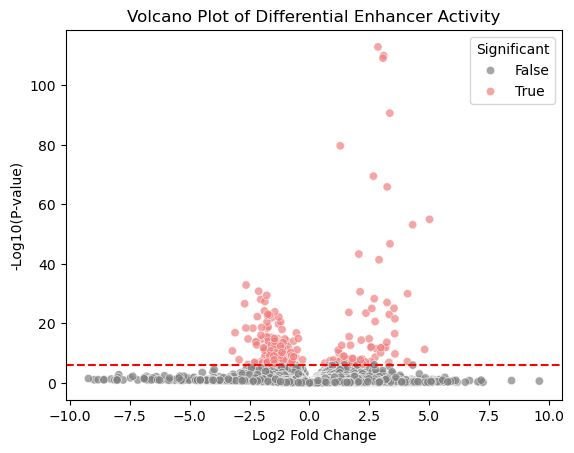

In [8]:
'''Volcano Plot'''

# Significance threshold with multiple-testing correction.
thresh = 0.05 / results.shape[0]
results["Significant"] = results["P-Value"] < thresh  

# Plot of data.
sns.scatterplot(data=results, x="Log2FC", y=-np.log10(results["P-Value"]),
                hue="Significant", alpha=0.7, palette=["grey", "lightcoral"])
plt.axhline(-np.log10(thresh), color="red", linestyle="--")  
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(P-value)")
plt.title("Volcano Plot of Differential Enhancer Activity")
plt.show()

##### Enhancer-Gene Mapping for Statistically Significant Regions

We want to get the genes associated with each statistically signficant region. 

In [9]:
'''Preprocessing for Enhancer-Gene Mapping'''

# Get only statistically significant enhancer regions.
de_enhancer_activity = results[results["Significant"]]
de_enhancer_activity = de_enhancer_activity.copy()

# Split index column into usable format for comparsion with gene annotations.
de_enhancer_activity[["Chromosome", "Start", "End"]] = de_enhancer_activity["Enhancer Region Index"].str.extract(r'(.+)_(\d+)_(\d+)')
de_enhancer_activity["Start"] = de_enhancer_activity["Start"].astype(int)
de_enhancer_activity["End"] = de_enhancer_activity["End"].astype(int)

de_enhancer_activity[["Enhancer Region Index", "Chromosome", "Start", "End", "Log2FC", "P-Value"]]

,Enhancer Region Index,Chromosome,Start,End,Log2FC,P-Value
24,chr1_209700000_209750000,chr1,209700000,209750000,1.293157,7.514218e-07
35,chr1_7300000_7350000,chr1,7300000,7350000,-1.731944,1.487680e-13
156,chr1_153050000_153100000,chr1,153050000,153100000,1.283638,4.805657e-08
284,chr1_7050000_7100000,chr1,7050000,7100000,-1.123730,1.986394e-07
285,chr1_7200000_7250000,chr1,7200000,7250000,-1.521737,9.210442e-09
...,...,...,...,...,...,...
60104,chrUn_KI270519v1_50000_100000,chrUn_KI270519v1,50000,100000,3.533990,8.339765e-26
60386,chrX_9800000_9850000,chrX,9800000,9850000,-2.206480,1.663387e-13
61469,chrX_8550000_8600000,chrX,8550000,8600000,-1.462804,3.460926e-07
61485,chrX_9850000_9900000,chrX,9850000,9900000,-1.477702,1.713417e-08


In [10]:
'''Read in Gene Annotation'''

# Basic gene annotation file for Hg38 samples.
gtf = read_gtf("gencode.v44.basic.annotation.gtf")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [11]:
'''Preprocessing Gene Annotation File'''

# Preprocess the gene annotation files into a usable format for enhancer-gene
# mapping.
gene_annot = pd.DataFrame(gtf[["feature", "seqname", "start", "end", "gene_name"]])
gene_annot = gene_annot.rename(columns={0: "feature", 1: "Chromosome", 2: "Start", 3: "End", 4: "gene_name"})
gene_annot = gene_annot[gene_annot["feature"] == "gene"]

gene_annot = gene_annot[["Chromosome", "Start", "End", "gene_name"]]
gene_annot['Start'] = gene_annot['Start'].astype(int)
gene_annot['End'] = gene_annot['End'].astype(int)

gene_annot

,Chromosome,Start,End,gene_name
0,chr1,11869,14409,DDX11L2
5,chr1,12010,13670,DDX11L1
13,chr1,14404,29570,WASH7P
26,chr1,17369,17436,MIR6859-1
29,chr1,29554,31109,MIR1302-2HG
...,...,...,...,...
1998512,chrM,14149,14673,MT-ND6
1998517,chrM,14674,14742,MT-TE
1998520,chrM,14747,15887,MT-CYB
1998525,chrM,15888,15953,MT-TT


In [13]:
'''Enhancer-Gene Mapping'''

# Collect resulting nearest genes.
mapped_enhancers = []

# Brute force algorithm to check nearest genes for each signficant enhancer 
# region. Gets genes that overlap with enhancer region.
for _, enhancer in de_enhancer_activity.iterrows():
    chrom = enhancer["Chromosome"]
    start = enhancer["Start"]
    end = enhancer["End"]
    overlapping_genes = gene_annot[
        (gene_annot["Chromosome"] == chrom) &
        (gene_annot["Start"] <= end) &
        (gene_annot["End"] >= start)
    ]
    for _, gene in overlapping_genes.iterrows():
        mapped_enhancers.append({
            "Enhancer": enhancer["Enhancer Region Index"],
            "Gene": gene["gene_name"],
            "Log2FC": enhancer["Log2FC"],
            "P-Value": enhancer["P-Value"] 
        })

# Convert into dataframe.
mapped_df = pd.DataFrame(mapped_enhancers)

# mapped_df.to_csv("dgr_scChIP_seq_genes.csv")
mapped_df

,Enhancer,Gene,Log2FC,P-Value
0,chr1_209700000_209750000,HSD11B1-AS1,1.293157,7.514218e-07
1,chr1_209700000_209750000,HSD11B1,1.293157,7.514218e-07
2,chr1_209700000_209750000,ADORA2BP1,1.293157,7.514218e-07
3,chr1_7300000_7350000,CAMTA1,-1.731944,1.487680e-13
4,chr1_153050000_153100000,SPRR2A,1.283638,4.805657e-08
...,...,...,...,...
773,chrX_8550000_8600000,ANOS1,-1.462804,3.460926e-07
774,chrX_9850000_9900000,SHROOM2,-1.477702,1.713417e-08
775,chrX_9850000_9900000,HMGN1P33,-1.477702,1.713417e-08
776,chrX_9850000_9900000,Y_RNA,-1.477702,1.713417e-08
